In [48]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing as mp
from threading import Thread
from math import erf
from scipy import optimize

### Definition of the Nonstationary Environment

In [49]:
class MultiProductPricingEnvironment:
    def __init__(self, products,
                 means,
                 covs,
                 seed=42,
                 plot_distribution=True,
                  ):
        self.products = products
        self.d = len(products)
        self.means, self.covs = self.delta_method_latent_from_logitnormal(means, covs)
        self.rng = np.random.default_rng(seed)
        self.current_vals = None

        if plot_distribution:
            n_samples = 100_000
            bins=100
            samples = self.sample_valuations(n_samples)
            for i, product in enumerate(products):

                plt.figure(figsize=(7, 3))
                plt.hist(samples[:, i], bins=bins, density=True)
                plt.title(f"Distribution of valuations for product {product} (100000 rounds)")
                plt.xlabel("valuation")
                plt.ylabel("density")
                plt.xlim(0, 1)
                plt.tight_layout()
                plt.show()


    def compute_Q(self, prices_grid, eps = 1e-12):

        dvs = np.sqrt(np.clip(np.diag(self.covs), 0.0, None))

        pc = np.clip(prices_grid, eps, 1 - eps)
        logits = np.log(pc / (1 - pc))

        Phi = lambda x: 0.5 * (1.0 + np.vectorize(erf)(x / np.sqrt(2.0)))
        z = (logits[None, :] - self.means[:, None]) / np.where(dvs > 0, dvs, 1.0)[:, None]
        Q = 1.0 - Phi(z)

        Q[:, prices_grid <= 0.0] = 1.0
        Q[:, prices_grid >= 1.0] = 0.0

        # If there are determinist prices (zero variance), set the prices above the valuation to 0 and 1 below
        det = dvs == 0.0
        if np.any(det):
            v = 1.0 / (1.0 + np.exp(-self.means[det]))
            Q[det] = (v[:, None] >= prices_grid[None, :]).astype(float)
        return Q



    @staticmethod
    def delta_method_latent_from_logitnormal(m, C):
        """
        Approximate latent Gaussian parameters (mu, Sigma_Z) for a multivariate logit-normal
        with desired mean vector m in (0,1)^d and covariance C.

        Uses first-order delta method:
            J = diag( m_i * (1 - m_i) )
            Sigma_Z ≈ J^{-1} C J^{-1}
            mu ≈ logit(m)
        """
        m = np.asarray(m, dtype=float)
        C = np.asarray(C, dtype=float)
        if m.ndim != 1:
            raise ValueError("m must be a 1-D array of means in (0,1).")
        if C.shape != (m.size, m.size):
            raise ValueError("C must be a square matrix with same dimension as m.")
        if np.any((m <= 0) | (m >= 1)):
            raise ValueError("All entries of m must lie strictly in (0,1).")

        mu = logit(m)
        gprime = m * (1.0 - m)  # derivative of expit at mu where expit(mu)=m
        if np.any(gprime <= 0):
            raise ValueError("Means too close to 0 or 1 make the delta method unstable.")
        Jinv = np.diag(1.0 / gprime)
        Sigma_Z = Jinv @ C @ Jinv
        # Symmetrize small numerical asymmetry
        Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T)
        return mu, Sigma_Z

    def get_current_means(self):
        """Compute non-stationary means."""
        current_means = self.rng.uniform(0.01, 0.99, size=self.d)
        return current_means

    def sample_valuations(self, n=1):
        self.means = self.get_current_means()
        z = self.rng.multivariate_normal(self.means, self.covs, size=n)
        vals = expit(z)
        if n == 1:
            self.current_vals = vals.ravel()
        else:
            self.current_vals = vals
        return self.current_vals

    def round(self, chosen_prices):
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = np.multiply(chosen_prices_arr, sold)
        return reward, sold


In [50]:
import numpy as np
from scipy.stats import beta

def alpha_from_mean_cov(mean, cov):
    """
    Recover Dirichlet parameters alpha from target mean and covariance.
    Args:
        mean: array-like of length d (must sum to 1)
        cov: covariance matrix (d×d)
    Returns:
        alpha: estimated Dirichlet parameters
    """
    mean = np.asarray(mean, dtype=float)
    cov = np.asarray(cov, dtype=float)
    d = len(mean)

    # Estimate alpha0 from diagonal entries (variances)
    alpha0_estimates = []
    for i in range(d):
        var = cov[i, i]
        if var > 0:
            alpha0_i = mean[i] * (1 - mean[i]) / var - 1.0
            if alpha0_i > 0:
                alpha0_estimates.append(alpha0_i)
    if len(alpha0_estimates) == 0:
        raise ValueError("Could not infer alpha0 from given covariance")

    alpha0 = np.mean(alpha0_estimates)
    alpha = mean * alpha0
    return alpha


def mean_cov_from_alpha(alpha):
    """
    Compute mean and covariance of Dirichlet given alpha.
    """
    alpha = np.asarray(alpha, dtype=float)
    a0 = np.sum(alpha)
    mean = alpha / a0

    denom = a0**2 * (a0 + 1.0)
    cov = -np.outer(alpha, alpha) / denom
    np.fill_diagonal(cov, alpha * (a0 - alpha) / denom)

    return mean, cov



class DirichletPricingEnvironment:

      def __init__(self, products, alpha=None, mean=None, cov=None):
        self.products = products
        self.d = len(products)

        if alpha is not None:
            self.alpha = np.asarray(alpha, dtype=float)
        elif mean is not None and cov is not None:
            mean = np.asarray(mean, dtype=float)
            cov = np.asarray(cov, dtype=float)
            self.alpha = alpha_from_mean_cov(mean, cov)
        else:
            raise ValueError("Provide either alpha or (mean and cov)")
        self.alpha0 = np.sum(self.alpha)
        self.current_vals = None  # store last sampled valuations

      def get_mean_cov(self):
        """
        Export implied mean and covariance from current alpha.
        """
        return mean_cov_from_alpha(self.alpha)

      def get_current_alpha(self):
        """
        Export current alpha.
        """
        return self.alpha

      def sample_valuations(self):
        self.current_vals = np.random.dirichlet(self.alpha)
        return self.current_vals

      def round(self, chosen_prices):
          """
          Simulate one round of sales.

          Args:
              chosen_prices (dict): Mapping {product_name: price}.

          Returns:
              reward (np.ndarray): Per-product revenue earned this round.
              sold (np.ndarray): 0/1 indicator for items sold.
              sale_probs (np.ndarray): Valuations from Dirichlet (sale "probabilities").
          """
          chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)

          vals = self.sample_valuations()
          sold = (vals >= chosen_prices_arr).astype(int)

          reward = np.multiply(chosen_prices_arr, sold)

          return reward, sold

      def compute_Q(self, prices_grid, eps=1e-12):
          """
          Closed-form purchase probabilities under Dirichlet environment.
          Args:
              prices_grid (1D array): candidate prices in [0,1].
          Returns:
              Q (array shape d × len(prices_grid)): purchase probabilities.
          """
          prices_grid = np.clip(prices_grid, eps, 1 - eps)
          num_prices = len(prices_grid)
          Q = np.zeros((self.d, num_prices))

          for i in range(self.d):
              a = self.alpha[i]
              b = self.alpha0 - a
              # Beta CDF
              cdf_vals = beta.cdf(prices_grid, a, b)
              Q[i, :] = 1.0 - cdf_vals

          return Q


In [51]:
import numpy as np
from scipy.stats import beta

class NonStationaryDirichletPricingEnvironment:
    """
    Non-stationary Dirichlet pricing environment.
    Alpha parameters evolve over time.
    """

    def __init__(self, products, alpha=None, mean=None, cov=None, alpha_update_std=0.1, seed=None):
        self.products = products
        self.d = len(products)
        self.alpha_update_std = alpha_update_std
        self.rng = np.random.default_rng(seed)

        if alpha is not None:
            self.alpha = np.asarray(alpha, dtype=float)
        elif mean is not None and cov is not None:
            mean = np.asarray(mean, dtype=float)
            cov = np.asarray(cov, dtype=float)
            self.alpha = alpha_from_mean_cov(mean, cov)
        else:
            raise ValueError("Provide either alpha or (mean and cov)")

        self.alpha0 = np.sum(self.alpha)

    def get_mean_cov(self):
        """Export implied mean and covariance from current alpha."""
        return mean_cov_from_alpha(self.alpha)

    def get_current_alpha(self):
        """Export current alpha."""
        return self.alpha

    def update_alpha(self):
        """
        Non-stationary update of alpha parameters.
        Adds Gaussian noise and ensures positivity.
        """
        noise = self.rng.normal(loc=0.0, scale=self.alpha_update_std, size=self.d)
        self.alpha = np.clip(self.alpha + noise, 1e-3, None)  # keep positive
        self.alpha0 = np.sum(self.alpha)

    def sample_valuations(self):
        """Sample valuations (in [0,1]) for each product using Dirichlet."""
        self.current_probs = self.rng.dirichlet(self.alpha)
        return self.current_probs

    def round(self, chosen_prices):
        """
        Simulate one round of sales.
        Updates alpha to introduce non-stationarity.
        """
        self.update_alpha()  # alpha changes each round

        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = chosen_prices_arr * sold
        return reward, sold

    def compute_Q(self, prices_grid, eps=1e-12):
        """
        Closed-form purchase probabilities (based on current alpha)
        """
        prices_grid = np.clip(prices_grid, eps, 1 - eps)
        num_prices = len(prices_grid)
        Q = np.zeros((self.d, num_prices))

        for i in range(self.d):
            a = self.alpha[i]
            b = self.alpha0 - a
            cdf_vals = beta.cdf(prices_grid, a, b)
            Q[i, :] = 1.0 - cdf_vals

        return Q


In [74]:
import numpy as np
from scipy.stats import beta

class HighlyNonStationaryDirichletEnv(DirichletPricingEnvironment):
    def __init__(self, products, alpha=None, mean=None, cov=None,
                 alpha_jump_std=1, seed=None):
        super().__init__(products, alpha=alpha, mean=mean, cov=cov)
        self.alpha_jump_std = alpha_jump_std
        self.rng = np.random.default_rng(seed)


    def sample_valuations(self):
        # Random jump in alpha to simulate non-stationarity
        jumps = self.rng.normal(0, self.alpha_jump_std, size=self.d)
        self.alpha = np.clip(self.alpha + jumps, 1e-3, None)
        self.alpha0 = np.sum(self.alpha)
        self.current_vals = np.random.dirichlet(self.alpha)
        return self.current_vals

    def round(self, chosen_prices):
        """Simulate one round with highly non-stationary alphas."""
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = chosen_prices_arr * sold
        return reward, sold

    def compute_Q(self, prices_grid, eps=1e-12):
        """Closed-form purchase probabilities for clairvoyant evaluation."""
        prices_grid = np.clip(prices_grid, eps, 1 - eps)
        num_prices = len(prices_grid)
        Q = np.zeros((self.d, num_prices))

        for i in range(self.d):
            a = self.alpha[i]
            b = self.alpha0 - a
            cdf_vals = beta.cdf(prices_grid, a, b)
            Q[i, :] = 1.0 - cdf_vals

        return Q

    def get_current_alpha(self):
        return self.alpha


In [53]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_environment(wrapper, n_rounds=50, prices=None):
    """
    Visualize environment dynamics over multiple rounds.

    Args:
        wrapper: PricingEnvironmentWrapper instance
        n_rounds: number of rounds to simulate
        prices: dict of chosen prices per product (optional)
    """
    products = wrapper.get_products()
    d = len(products)

    if prices is None:
        # Default price for all products
        prices = {p: 0.5 for p in products}

    # Histories
    sampled_vals_history = np.zeros((n_rounds, d))
    sold_history = np.zeros((n_rounds, d))
    alpha_history = None
    if hasattr(wrapper.env, "get_current_alpha"):
        alpha_history = np.zeros((n_rounds, d))

    for t in range(n_rounds):
        reward, sold = wrapper.round(prices)
        sold_history[t, :] = sold

        sampled_vals_history[t, :] = wrapper.get_current_vals()

        if alpha_history is not None:
            alpha_history[t, :] = wrapper.get_current_alpha()

    # Plot alpha evolution (if applicable)
    if alpha_history is not None:
        plt.figure(figsize=(12, 4))
        for i, p in enumerate(products):
            plt.plot(alpha_history[:, i], label=f"alpha_{p}")
        plt.title("Alpha evolution over time")
        plt.xlabel("Round")
        plt.ylabel("Alpha values")
        plt.legend()
        plt.show()

    # Plot sampled valuations
    plt.figure(figsize=(12, 4))
    for i, p in enumerate(products):
        plt.plot(sampled_vals_history[:, i], label=f"sampled_val_{p}")
    plt.title("Sampled valuations over time")
    plt.xlabel("Round")
    plt.ylabel("Valuation")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Plot sold items
    plt.figure(figsize=(12, 4))
    for i, p in enumerate(products):
        plt.plot(sold_history[:, i], label=f"sold_{p}", marker='o', linestyle='')
    plt.title("Sold items over time")
    plt.xlabel("Round")
    plt.ylabel("Sold (0/1)")
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.show()


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_nonstationary_dirichlet(env, n_rounds=50, prices=None):
    """
    Visualize alpha evolution and sampled purchase probabilities over time.

    Args:
        env: HighlyNonStationaryDirichletEnv instance
        n_rounds: number of rounds to simulate
        prices: dict of chosen prices per product (optional)
    """
    d = len(env.products)
    alpha_history = np.zeros((n_rounds, d))
    sampled_vals = np.zeros((n_rounds, d))
    sold_history = np.zeros((n_rounds, d))

    if prices is None:
        prices = {p: 0.5 for p in env.products}  # default prices

    for t in range(n_rounds):
        reward, sold = env.round(prices)
        alpha_history[t, :] = env.get_current_alpha()
        sampled_vals[t, :] = env.current_probs
        sold_history[t, :] = sold

    # Plot alpha evolution
    plt.figure(figsize=(12, 4))
    for i, p in enumerate(env.products):
        plt.plot(alpha_history[:, i], label=f"alpha_{p}")
    plt.title("Alpha evolution over time")
    plt.xlabel("Round")
    plt.ylabel("Alpha values")
    plt.legend()
    plt.show()

    # Plot sampled purchase probabilities
    plt.figure(figsize=(12, 4))
    for i, p in enumerate(env.products):
        plt.plot(sampled_vals[:, i], label=f"sampled_prob_{p}")
    plt.title("Sampled purchase probabilities over time")
    plt.xlabel("Round")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Optional: plot sold items
    plt.figure(figsize=(12, 4))
    for i, p in enumerate(env.products):
        plt.plot(sold_history[:, i], label=f"sold_{p}", marker='o', linestyle='')
    plt.title("Sold items over time")
    plt.xlabel("Round")
    plt.ylabel("Sold (0/1)")
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.show()


In [80]:
class PricingEnvironmentWrapper:
    def __init__(self, products, env_type="dirichlet",
                 alpha=None, mean=None, cov=None,
                 non_stationary=True, alpha_jump_std=1, seed=None):
        self.products = products
        self.d = len(products)
        self.env_type = env_type

        if env_type == "dirichlet":
            if non_stationary:
                self.env = HighlyNonStationaryDirichletEnv(
                    products, alpha=alpha, mean=mean, cov=cov,
                    alpha_jump_std=alpha_jump_std, seed=seed
                )
            else:
                self.env = DirichletPricingEnvironment(
                    products, alpha=alpha, mean=mean, cov=cov
                )
        elif env_type == "logitnormal":
            if mean is None or cov is None:
                raise ValueError("Logit-Normal requires mean and cov.")
            self.env = MultiProductPricingEnvironment(products, means=mean, covs=cov, seed=seed)
        else:
            raise ValueError("env_type must be 'dirichlet' or 'logitnormal'.")

    def round(self, chosen_prices):
        reward, sold = self.env.round(chosen_prices)
        return reward, sold

    def compute_Q(self, prices_grid):
        if not hasattr(self.env, "compute_Q"):
            raise NotImplementedError(f"{self.env_type} environment does not implement compute_Q")
        return self.env.compute_Q(prices_grid)

    def get_products(self):
        return self.products

    def get_current_vals(self):
        """Return last sampled valuations (all environments support this now)."""
        return self.env.current_vals




### Definition of the Primal-Dual Agent

In [57]:
import numpy as np

class EXP3PAgent:
    """
    EXP3.P agent for adversarial bandits with K arms.
    Numerically stable and compatible with probability distributions that may include zeros.
    """

    def __init__(self, K, T, alpha, gamma):
        """
        Args:
            K (int): number of arms
            T (int): time horizon
            alpha (float): exploration bias parameter
            gamma (float): exploration mixing parameter
        """
        self.K = K
        self.T = T
        self.alpha = alpha
        self.gamma = gamma
        self.t = 0

        # Initialize weights
        self.weights = np.ones(K, dtype=float)
        self.probs = np.ones(K) / K
        self.N_pulls = np.zeros(K, dtype=int)
        self.a_t = None

    def pull_arm(self):
        self.probs = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        self.probs = np.clip(self.probs, 1e-12, 1.0)  # prevent zeros
        self.probs /= np.sum(self.probs)
        self.a_t = np.random.choice(self.K, p=self.probs)
        return self.a_t

    def update(self, reward):
        i = self.a_t
        self.t += 1
        self.N_pulls[i] += 1

        safe_probs = np.clip(self.probs, 1e-12, 1.0)
        x_hat = np.zeros(self.K, dtype=float)
        x_hat[i] = reward / safe_probs[i]

        bias_term = self.alpha / np.sqrt(self.K * self.T)
        x_hat += bias_term / safe_probs

        # Clip to avoid overflow
        max_exp = 700
        x_hat = np.clip(x_hat, -max_exp, max_exp)

        self.weights *= np.exp((self.gamma / self.K) * x_hat)
        self.weights = np.clip(self.weights, 1e-12, 1e100)  # numerical safety





In [58]:
class PrimalDualPricingAgent:
    def __init__(self, products, prices, budget, T, eta, K):
        self.products = products
        self.prices = prices
        self.K = K
        self.budget = budget
        self.initial_budget = budget
        self.T = T
        self.eta = eta
        self.lmbd = 1.0  # Lagrange multiplier
        self.t = 0
        self.rho = self.initial_budget/self.T

        # One EXP3P agent per product
        self.agents = {p: EXP3PAgent(K=K, T=T,
                                     alpha=2*np.sqrt(K*T)*3,
                                     gamma=min(3/5, 2 * np.sqrt((3*K*np.log(K))/(5*T))))
                       for p in products}

        # To track chosen indices for update
        self.price_indices = {p: 0 for p in products}

    def pull_prices(self):
        chosen_prices_idx = {}
        for p, agent in self.agents.items():
            if self.budget <= 0:
                chosen_prices_idx[p] = -1
            else:
                chosen_prices_idx[p] = agent.pull_arm()
        self.price_indices = chosen_prices_idx

        chosen_prices = {p: self.prices[p][idx] if idx >= 0 else 0
                         for p, idx in chosen_prices_idx.items()}
        return chosen_prices

    def update(self, rewards, costs):
        self.t += 1
        total_cost = np.sum(costs)

        # Dual update: increase λ if budget usage is high, decrease otherwise
        total_cost_per_product = total_cost / len(self.products)
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-total_cost_per_product),
                            a_min=0, a_max=1/self.rho)
        rewards = {p: rewards[i] for i, p in enumerate(self.products)}
        costs   = {p: costs[i]   for i, p in enumerate(self.products)}
        # Primal update per product
        for p, agent in self.agents.items():
            idx = self.price_indices[p]
            if idx >= 0:
                # Lagrangian reward: reward - λ * cost
                L = rewards[p] - self.lmbd * costs[p]
                # L = max(L, 0)
                agent.update(L)

        # Update remaining budget
        self.budget -= total_cost


### Baseline

In [59]:
def compute_clairvoyant_multi(products, prices_grid, env, rho, cost=0.0):
    """
    Clairvoyant LP for multiple products with different valuations,
    same candidate prices but different sale probabilities.

    Args:
        products: list of product names
        prices_grid: 1D array of candidate prices (same for all products)
        env: MultiProductPricingEnvironment (has compute_Q)
        rho: global expected total sales per round
        cost: optional unit cost

    Returns:
        gamma: dict product -> array of probabilities over prices
        expected_reward: float
        expected_total_sales: float
    """
    prices_grid = np.array(prices_grid)
    num_products = env.d
    num_prices = len(prices_grid)

    # Compute sale probabilities analytically
    Q = env.compute_Q(prices_grid)  # shape: num_products × num_prices

    # Flatten for LP
    all_prices = np.tile(prices_grid, num_products)
    all_qs = Q.flatten()

    # Objective: maximize expected revenue
    c = - (all_prices - cost) * all_qs

    # Global expected sales constraint
    A_ub = [all_qs]
    b_ub = [rho]

    # Per-product normalization
    A_eq = []
    b_eq = []
    for i in range(num_products):
        row = np.zeros_like(all_prices)
        row[i*num_prices:(i+1)*num_prices] = 1.0
        A_eq.append(row)
        b_eq.append(1.0)
    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)

    # Solve LP
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq,
                           bounds=(0,1), method='highs')

    gamma = {}
    if res.success:
        for i, p in enumerate(products):
            gamma[p] = res.x[i*num_prices:(i+1)*num_prices]
        expected_reward = -res.fun
        expected_total_sales = np.sum(all_qs * res.x)
    else:
        gamma = {p: np.ones(num_prices)/num_prices for p in products}
        expected_reward = None
        expected_total_sales = None

    return gamma, expected_reward, expected_total_sales


### Parallelization helper functions

In [61]:
def _progress_listener(q, n_trials, leave=False):
    """
    Render one tqdm bar per trial in the main process.
    Workers send ('init', trial_idx, total), ('update', trial_idx, n), ('close', trial_idx, 0).
    """
    bars = {}
    closed = set()
    while len(closed) < n_trials:
        msg = q.get()
        if msg is None:  # termination signal
            break
        kind, trial_idx, val = msg
        if kind == 'init':
            # Create the bar for this trial if not exists
            if trial_idx not in bars:
                bars[trial_idx] = tqdm(total=int(val),
                                       desc=f"Trial {trial_idx+1}",
                                       position=trial_idx,
                                       leave=leave)
        elif kind == 'update':
            if trial_idx in bars:
                bars[trial_idx].update(int(val))
        elif kind == 'close':
            if trial_idx in bars and trial_idx not in closed:
                bars[trial_idx].close()
                closed.add(trial_idx)

    # Ensure all bars are closed
    for tid, bar in bars.items():
        if tid not in closed:
            bar.close()

def _start_progress(n_trials, leave=False):
    mgr = mp.Manager()
    q = mgr.Queue()
    th = Thread(target=_progress_listener, args=(q, n_trials, leave), daemon=True)
    th.start()
    return q, th, mgr

# ----------------------------------------
# One trial (runs in a worker process)

def run_all_trials_parallel(seeds, products, prices, budget, T, eta, K, env_type, means, covs, n_jobs=-1, leave=False):
    progress_q, progress_thread, mgr = _start_progress(len(seeds), leave=leave)
    try:
        results = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(run_single_trial)(
                trial_idx, products, prices, budget, T, eta, K, env_type, means, covs, seed, progress_q
            )
            for trial_idx, seed in enumerate(seeds)
        )
    finally:
        # tell listener to exit if not already
        progress_q.put(None)
        progress_thread.join()
        mgr.shutdown()
    all_regrets = [np.cumsum(results[i][3]-results[i][0]) for i in range(len(results))]
    all_payments = [np.cumsum(results[i][2]) for i in range(len(results))]

    return all_regrets, all_payments


def run_single_trial(trial_idx, products, prices, budget, T, eta, K, env_type, means, covs, seed=42, progress_q=None):
    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    env = PricingEnvironmentWrapper(products, env_type, alpha=None, mean=means, cov=covs, seed=seed)
    visualize_environment(env, n_rounds=500)
    #     env = DirichletPricingEnvironment(products=products, mean=means, cov=covs)
    # else:
    #     env = MultiProductPricingEnvironment(products=products, means=means, covs=covs,
    #                                       seed=seed, T=T, plot_distribution=False)

    agent = PrimalDualPricingAgent(products, prices, budget, T, eta, K)
    rho = budget / T

    utilities = []
    clairv_util = []
    my_prices = []
    my_payments = []
    total_wins = 0

    for u in range(T):
        # Compute clairvoyant distribution with global budget constraint
        # Suppose prices is a dict: {product_name: array_of_candidate_prices}
        _, exp_clairv_util, _ = compute_clairvoyant_multi(products, prices_per_product, env, rho)
        clairv_util.append(exp_clairv_util)
        if agent.budget <= 0:
            rewards = [0 for p in products]
            costs = [0 for p in products]
            chosen_prices = {p: max(prices[p]) for p in products}
        else:
            # Agent chooses prices per product
            chosen_prices = agent.pull_prices()

            # Environment interaction
            rewards, costs = env.round(chosen_prices)

            agent.update(rewards, costs)

        # Logging
        utilities.append(sum(rewards))
        my_prices.append(chosen_prices)
        my_payments.append(sum(costs))
        total_wins += sum(costs)

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    print(f"Total # of Wins: {total_wins}")

    if progress_q is not None:
        progress_q.put(('close', trial_idx, 0))

    return (
        np.array(utilities),
        my_prices,                    # list of dicts of prices
        np.array(my_payments),
        np.array(clairv_util)
    )



In [78]:
def run_single_trial_viz(trial_idx, products, prices, budget, T, eta, K,
                     env_type, means, covs, seed=42, progress_q=None,
                     visualize=True, n_viz_rounds=500):
    """
    Run a single trial of the pricing experiment with an agent in a non-stationary environment.

    Tracks actual agent behavior if visualize=True, including total revenue per round.
    """
    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    # Initialize environment wrapper
    env = PricingEnvironmentWrapper(products, env_type, alpha=None, mean=means, cov=covs, seed=seed)

    # Initialize the pricing agent
    agent = PrimalDualPricingAgent(products, prices, budget, T, eta, K)
    rho = budget / T

    utilities = []
    clairv_util = []
    my_prices = []
    my_payments = []
    total_wins = 0

    # Histories for visualization
    if visualize:
        sampled_vals_history = np.zeros((n_viz_rounds, len(products)))
        sold_history = np.zeros((n_viz_rounds, len(products)))
        price_history = np.zeros((n_viz_rounds, len(products)))
        revenue_history = np.zeros(n_viz_rounds)
        alpha_history = None
        mean_history = None

        if env.env_type == "dirichlet" and hasattr(env.env, "get_current_alpha"):
            alpha_history = np.zeros((n_viz_rounds, len(products)))
        elif env.env_type == "logitnormal" and hasattr(env.env, "means"):
            mean_history = np.zeros((n_viz_rounds, len(products)))

    for u in range(T):
        # Compute clairvoyant distribution
        _, exp_clairv_util, _ = compute_clairvoyant_multi(products, prices_per_product, env, rho)
        clairv_util.append(exp_clairv_util)

        if agent.budget <= 0:
            rewards = [0 for _ in products]
            costs = [0 for _ in products]
            chosen_prices = {p: max(prices[p]) for p in products}
        else:
            # Agent chooses prices
            chosen_prices = agent.pull_prices()

            # Environment interaction
            rewards, costs = env.round(chosen_prices)

            # Update agent
            agent.update(rewards, costs)

        # Logging
        utilities.append(sum(rewards))
        my_prices.append(chosen_prices)
        my_payments.append(sum(costs))
        total_wins += sum(costs)

        # Track histories for visualization
        if visualize and u < n_viz_rounds:
            for i, p in enumerate(products):
                price_history[u, i] = chosen_prices[p]
            sold_history[u, :] = (np.array(rewards) > 0).astype(int)
            sampled_vals_history[u, :] = env.get_current_vals()
            revenue_history[u] = sum(rewards)
            if alpha_history is not None:
                alpha_history[u, :] = env.env.get_current_alpha()
            if mean_history is not None:
                mean_history[u, :] = env.env.means

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    print(f"Total # of Wins: {total_wins}")

    if progress_q is not None:
        progress_q.put(('close', trial_idx, 0))

    # Visualization of actual agent behavior
    if visualize:
        import matplotlib.pyplot as plt

        if alpha_history is not None:
            plt.figure(figsize=(12, 4))
            for i, p in enumerate(products):
                plt.plot(alpha_history[:, i], label=f"alpha_{p}")
            plt.title("Alpha evolution over time (Dirichlet)")
            plt.xlabel("Round")
            plt.ylabel("Alpha values")
            plt.legend()
            plt.show()

        if mean_history is not None:
            plt.figure(figsize=(12, 4))
            for i, p in enumerate(products):
                plt.plot(mean_history[:, i], label=f"mean_{p}")
            plt.title("Mean evolution over time (Logit-Normal)")
            plt.xlabel("Round")
            plt.ylabel("Mean values")
            plt.legend()
            plt.show()

        # Sampled valuations
        plt.figure(figsize=(12, 4))
        for i, p in enumerate(products):
            plt.plot(sampled_vals_history[:, i], label=f"sampled_val_{p}")
        plt.title("Sampled valuations over time")
        plt.xlabel("Round")
        plt.ylabel("Valuation")
        plt.ylim(0, 1)
        plt.legend()
        plt.show()


    return (
        np.array(utilities),
        my_prices,
        np.array(my_payments),
        np.array(clairv_util)
    )


Discretizing prices with 17 values
Total # of Wins: 6000


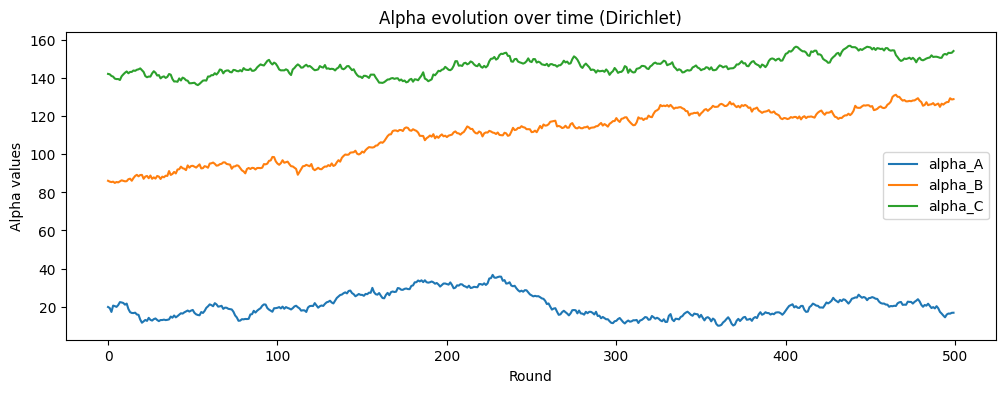

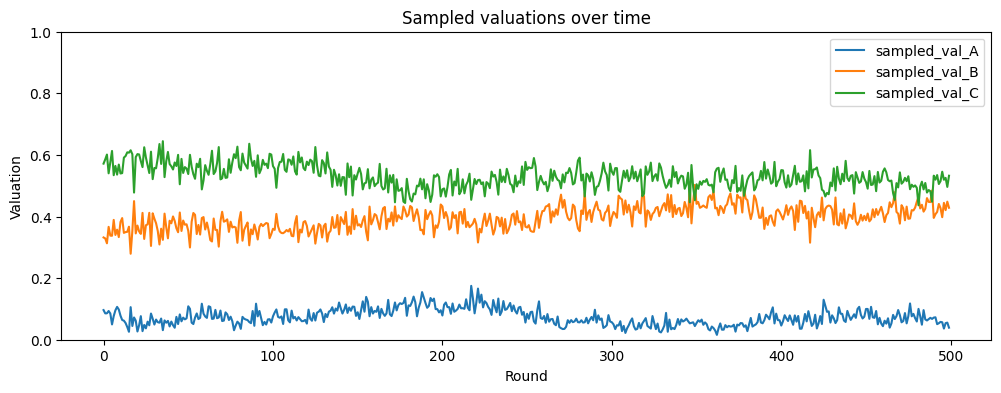

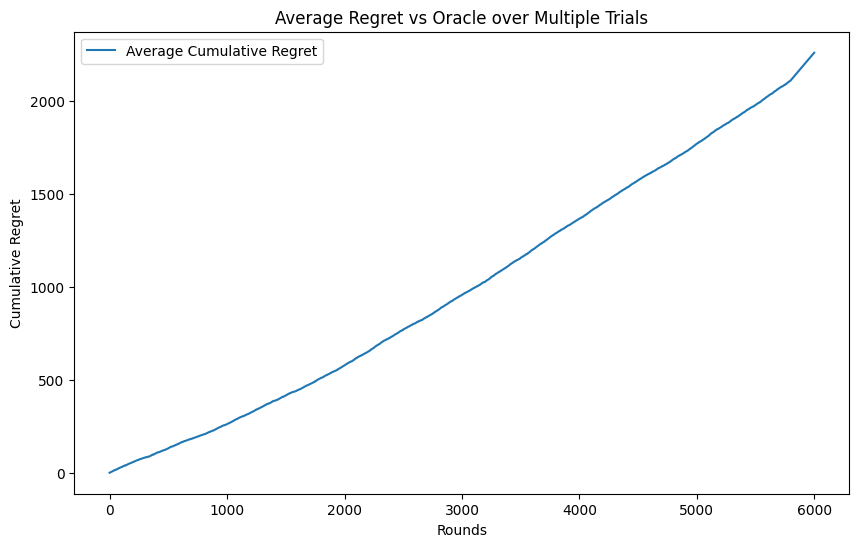

In [92]:
run_one = 1
products = ['A','B','C']
budget = 6000
T = 6000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123567]
envT = 1

if envT == 0:
    env_type = 'logitnormal'
else:
    env_type = 'dirichlet'

epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {p: prices_per_product for p in products}

means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[1., 0.5, 0.5],
                       [0.5, 2., 0.5],
                       [0.5, 0.5, 0.5]])

eta = T**(-0.5)   # 🔥 choose a learning rate for λ (important!)
if run_one:
    utilities, _, _, clairv_util = run_single_trial_viz(0, products, prices, budget, T, eta, K, env_type, means, covs, seed=3)
    cum_utilities = np.cumsum(utilities)
    cum_clairv = np.cumsum(clairv_util)
    avg_regret = cum_clairv - cum_utilities

    plt.figure(figsize=(10,6))
    plt.plot(avg_regret, label='Average Cumulative Regret')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Regret')
    plt.title('Average Regret vs Oracle over Multiple Trials')
    plt.legend()
    plt.show()
else:
    all_regrets, all_payments = run_all_trials_parallel(
    seeds, products, prices, budget, T, eta, K, env_type, means, covs, n_jobs=-1
)

# Pad regrets to equal length
all_regrets = np.array([np.pad(r[:T], (0, T - len(r[:T])), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-267946643.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


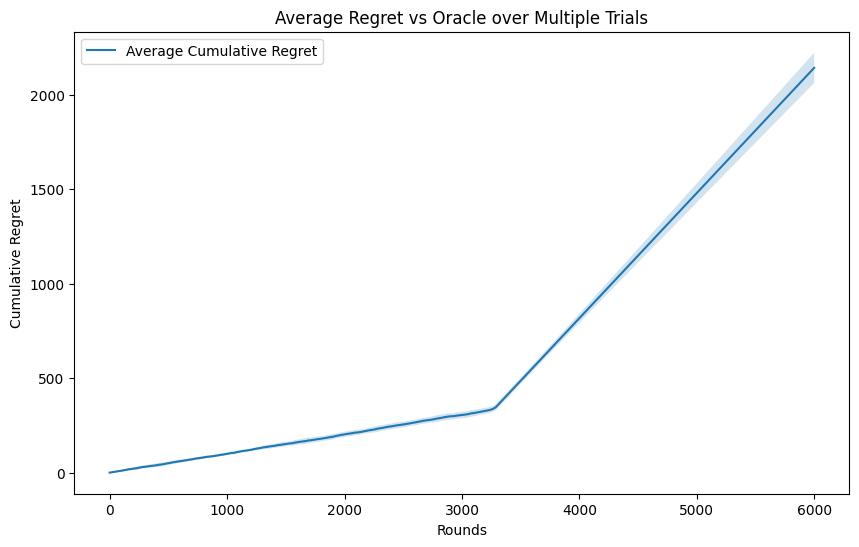

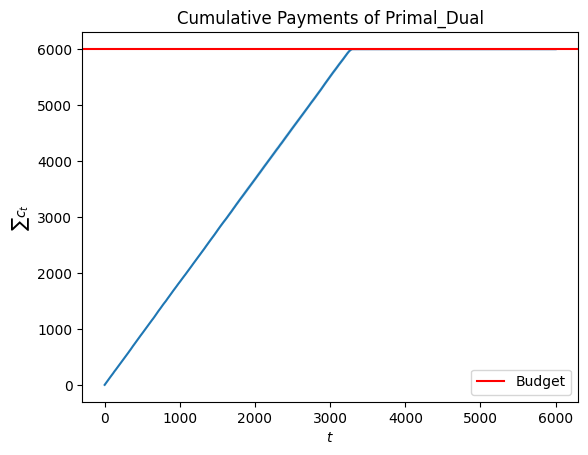

In [90]:
plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.2)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Primal_Dual')
plt.show()